In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import colors, ticker

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

from tqdm.notebook import tqdm


# path = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/data')
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
path_stats = path

hearts = ['E10691_RBM20', 'E11444_LMNA', 'E10927_MYBPC3']

# hearts = ['E10691_RBM20',
#           'E11442_TTN',
#           'E10621_ABCC9',
#           'E11444_LMNA',
#           'E10615_MYH7',
#           'E11443_LMNA',
#           'E11971_MYH7',
#           'E10927_MYBPC3',
#           'E10884',
#           'E10788_LMNA']

In [2]:
data = {}
data_gen = {}
data_ds = {}

for heart in hearts:
    stats_loader = StatsLoader(path_stats,
                               subdir='Stats',
                               collected_columns=['area'])
    data[heart] = stats_loader.load_heart_data(heart)

    stats_loader = StatsLoader(path_stats,
                               subdir='StatsDS',
                               collected_columns=['area'])
    data_ds[heart] = stats_loader.load_heart_data(heart)

    stats_loader = StatsLoader(path_stats,
                               subdir='StatsGenerated',
                               collected_columns=['area'])
    data_gen[heart] = stats_loader.load_heart_data(heart)

1/1: 100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


In [3]:
def count_area(df, dens_min=0, dens_max=1):
    df = df[df['density'].between(dens_min, dens_max)]

    area_count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[area_count > 0]
    area_count = area_count[area_count > 0]

    return area_count, area_bins

In [4]:
from statsmodels.stats.weightstats import DescrStatsW


for i, heart in enumerate(hearts):
    df = data[heart]
    df_ds = data_ds[heart]
    df_gen = data_gen[heart]

    print(heart)
    print('--------------------------------------')
    
    for j, (dens_min, dens_max) in enumerate([(0, 0.2),
                                              (0.2, 0.4),
                                              (0.4, 1),
                                              (0, 1)]):
        
        # df_d = df[df['density'].between(dens_min, dens_max)]
        # df_gen_d = df_gen[df_gen['density'].between(dens_min, dens_max)]
        
        for ddf in [df, df_ds, df_gen]:

            wq = DescrStatsW(data=ddf['area'].values, 
                            weights=ddf['area'].values)

            quant = wq.quantile(probs=np.array([0.05, 0.25, 0.5, 0.75, 0.95]),
                                return_pandas=False)
            # print(dens_min, dens_max)
            # print('--------------------------------------')
            print(*quant)
    print('--------------------------------------')

E10691_RBM20
--------------------------------------
6 55 417 3543 136751
3 38 293 2665 39532
1 1 2 6 1213
6 55 417 3543 136751
3 38 293 2665 39532
1 1 2 6 1213
6 55 417 3543 136751
3 38 293 2665 39532
1 1 2 6 1213
6 55 417 3543 136751
3 38 293 2665 39532
1 1 2 6 1213
--------------------------------------
E11444_LMNA
--------------------------------------
3 37 391 3426 78995
2 23 258 4298 118787
1 1 3 8 4272
3 37 391 3426 78995
2 23 258 4298 118787
1 1 3 8 4272
3 37 391 3426 78995
2 23 258 4298 118787
1 1 3 8 4272
3 37 391 3426 78995
2 23 258 4298 118787
1 1 3 8 4272
--------------------------------------
E10927_MYBPC3
--------------------------------------
9 807 225356 867820 1532975
5 323 86058 622450 1492040
1 3 22 152949 673575
9 807 225356 867820 1532975
5 323 86058 622450 1492040
1 3 22 152949 673575
9 807 225356 867820 1532975
5 323 86058 622450 1492040
1 3 22 152949 673575
9 807 225356 867820 1532975
5 323 86058 622450 1492040
1 3 22 152949 673575
------------------------------

In [5]:
data_all = []
data_gen_all = []
data_ds_all = []

for heart in hearts:
    df = data[heart]
    df['heart'] = heart
    data_all.append(df)

    df_gen = data_gen[heart]
    df_gen['heart'] = heart
    data_gen_all.append(df_gen)

    df_ds = data_ds[heart]
    df_ds['heart'] = heart
    data_ds_all.append(df_ds)

data_all = pd.concat(data_all)
data_gen_all = pd.concat(data_gen_all)
data_ds_all = pd.concat(data_ds_all)

In [17]:
def calc_ccdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def draw_ccdf(df, ax, color='blue', label='Histological'):
    area_bins, ccdf = calc_ccdf(df)
    ax.plot(area_bins, ccdf, label=label, color=color)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Cluster Size', fontsize=16)
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticks([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    # cdf = np.cumsum(area)
    return area_bins, cdf


def draw_area_cdf(df, ax, color='blue', label='Histological'):
    area_bins, cdf = calc_area_cdf(df)
    ax.plot(area_bins, cdf, label=label, color=color)
    ax.set_xscale('log')
    ax.set_xlabel('Cluster Size', fontsize=16)
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


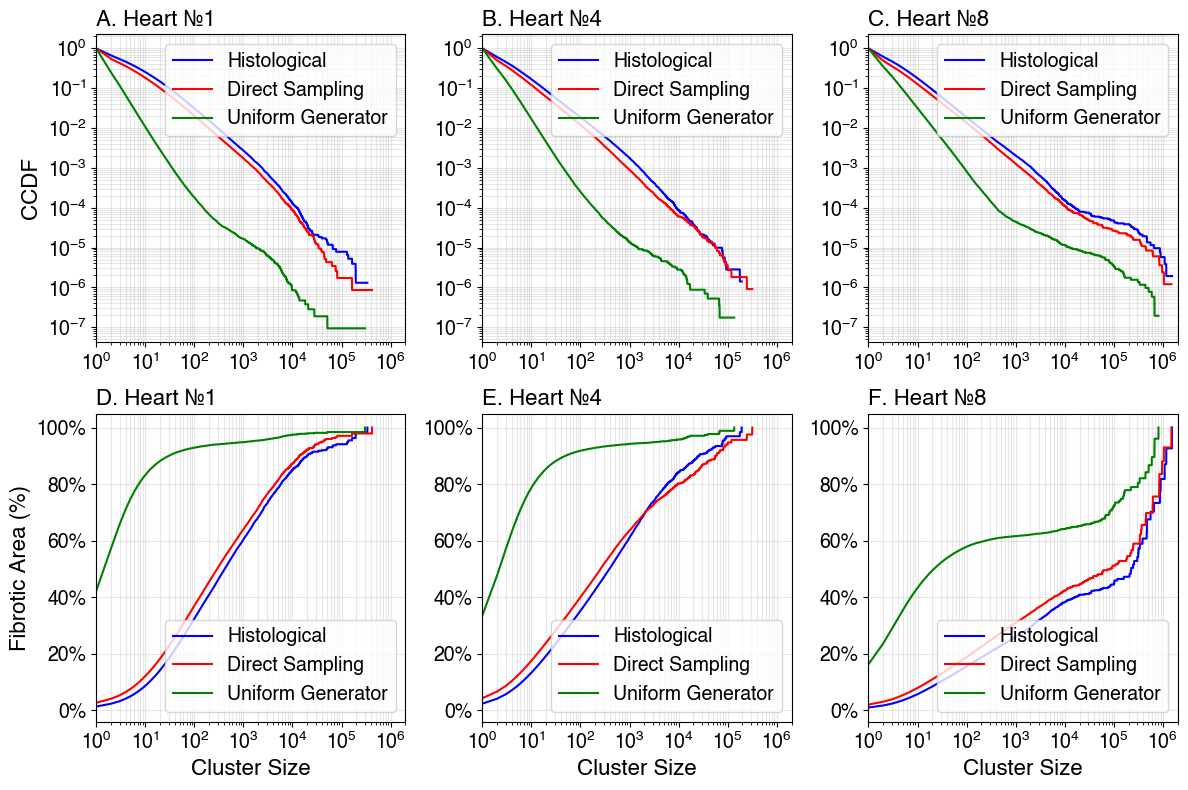

In [18]:
plt.rcParams.update({'font.family': 'Helvetica'})

titles = [['A. Heart №1', 'B. Heart №4', 'C. Heart №8'],
          ['D. Heart №1', 'E. Heart №4', 'F. Heart №8']]
COLORS = {'Histological': 'blue', 
          'Direct Sampling': 'red',
          'Uniform Generator': 'green'}

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), sharex=False)

for ax in axs[0]:
    ax.sharey(axs[0, 0])

for ax in axs[1]:
    ax.sharey(axs[1, 0])

for i, heart in enumerate(hearts):

    df = {'Histological': data[heart],
          'Uniform Generator': data_gen[heart],
          'Direct Sampling': data_ds[heart]}

    for k in ['Histological', 'Direct Sampling', 'Uniform Generator']:
        v = df[k]
        draw_ccdf(v, axs[0, i], color=COLORS[k], label=k)
        draw_area_cdf(v, axs[1, i], color=COLORS[k], label=k)

    
for i in range(2):
    for j in range(3):
        axs[i, j].set_title(titles[i][j], loc='left', fontsize=16)

for ax in axs.flat:
    ax.grid(True, alpha=0.3, which='both')
    ax.set_xlim(1, 2e6)

for ax in axs[0]:
    ax.legend(loc='upper right', fontsize=14)

for ax in axs[1]:
    ax.legend(loc='lower right', fontsize=14)

axs[0, 0].set_ylabel('CCDF', fontsize=16)

axs[1, 0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1, 0].set_ylabel('Fibrotic Area (%)', fontsize=16)


for i in range(3):
    axs[0, i].set_xlabel('')

# plt.subplots_adjust(top=0.8, bottom=0.05, right=0.9, left=0.05,
#                     wspace=0.05, hspace=0.15)
# fig.legend([line, line_gen], ['Histological', 'Uniform Generator'],
#            loc='upper center', ncol=2, prop={'size': 10})
plt.tight_layout()
plt.show()

In [19]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('cluster_size.png'),
            dpi=300, bbox_inches='tight')

In [12]:
stats_data = []

for i, heart in enumerate(hearts):

    df = {'Histological': data[heart],
          'Uniform Generator': data_gen[heart],
          'Direct Sampling': data_ds[heart]}

    for k in ['Histological', 'Direct Sampling', 'Uniform Generator']:
        v = df[k]

        area_bins, cdf = calc_area_cdf(v)
        area_bins, ccdf = calc_ccdf(v)
        stats_data.append(pd.DataFrame({'heart': [heart] * len(area_bins),
                                        'area_bins': area_bins,
                                        'cdf': cdf,
                                        'ccdf': ccdf,
                                        'source': [k] * len(area_bins)}))

stats_data = pd.concat(stats_data)
stats_data.head()

,heart,area_bins,cdf,ccdf,source
0,E10691_RBM20,1,0.013024,1.000000,Histological
1,E10691_RBM20,2,0.022946,0.666033,Histological
2,E10691_RBM20,3,0.031872,0.538820,Histological
3,E10691_RBM20,4,0.041011,0.462533,Histological
4,E10691_RBM20,5,0.049353,0.403943,Histological


In [21]:
def prob_thr(x, y, thr=10):
    return x[y > thr].max()


ccdf_data = {}
cdf_data = {}
for thr in [10, 100, 1000]:
    ccdf_data[f'P(s>{thr})'] = stats_data.groupby(['heart', 'source'])[['area_bins', 'ccdf']].apply(lambda x: prob_thr(x.ccdf, x.area_bins, thr))
print(pd.DataFrame(ccdf_data))

                                  P(s>10)  P(s>100)  P(s>1000)
heart         source                                          
E10691_RBM20  Direct Sampling    0.169038  0.020219   0.001741
              Histological       0.237634  0.031000   0.002706
              Uniform Generator  0.008921  0.000179   0.000017
E10927_MYBPC3 Direct Sampling    0.115525  0.013361   0.001267
              Histological       0.162755  0.018468   0.002039
              Uniform Generator  0.027331  0.000798   0.000044
E11444_LMNA   Direct Sampling    0.109608  0.011869   0.000893
              Histological       0.153898  0.018463   0.001765
              Uniform Generator  0.014025  0.000248   0.000014


In [24]:
def prob_thr(x, y, thr=10):
    return 100 * x[y >= thr].min()


cdf_data = {}
for thr in [1, 10, 100]:
    cdf_data[f'P(s<={thr})'] = stats_data.groupby(['heart', 'source'])[['area_bins', 'cdf']].apply(lambda x: prob_thr(x.cdf, x.area_bins, thr))

print(pd.DataFrame(cdf_data))

                                   P(s<=1)   P(s<=10)  P(s<=100)
heart         source                                            
E10691_RBM20  Direct Sampling     2.645798  12.035734  36.932359
              Histological        1.302416   8.620958  32.338423
              Uniform Generator  42.158086  83.184555  92.895879
E10927_MYBPC3 Direct Sampling     2.002034   7.877289  18.799593
              Histological        0.954983   5.678693  15.526396
              Uniform Generator  16.263607  43.279988  57.850921
E11444_LMNA   Direct Sampling     4.253332  17.502939  40.015799
              Histological        2.320103  13.271548  35.177796
              Uniform Generator  33.475109  78.693589  91.802791


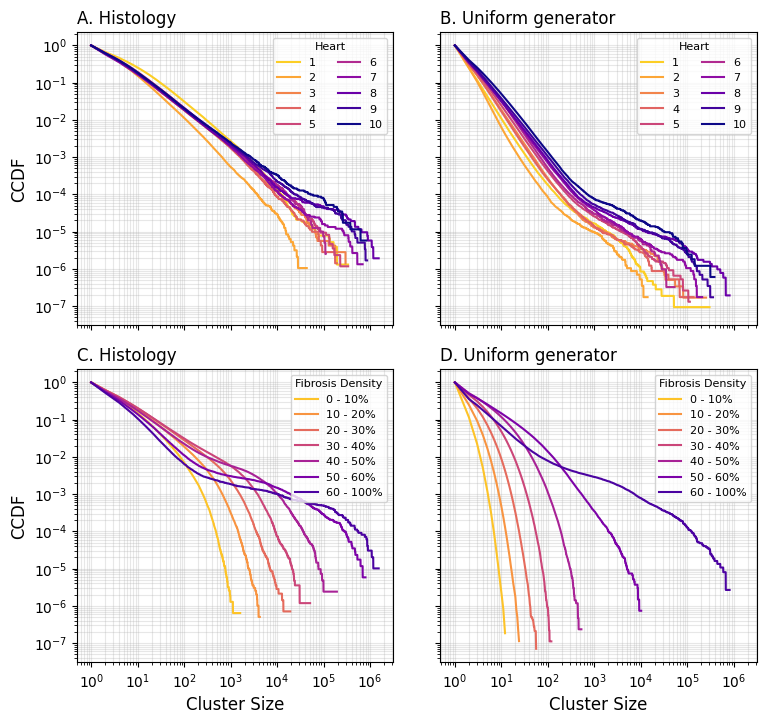

In [117]:
def calc_ccdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


heart_order = ['E10691_RBM20',
               'E11442_TTN',
               'E10621_ABCC9',
               'E11444_LMNA',
               'E10615_MYH7',
               'E11443_LMNA',
               'E11971_MYH7',
               'E10927_MYBPC3',
               'E10884',
               'E10788_LMNA']

colors_heart = plt.get_cmap('plasma_r')(np.linspace(0, 1, 1 + len(hearts)))[1:]
dens_bins = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1])
colors_dens = plt.get_cmap('plasma_r')(
    np.linspace(0, 1, 1 + len(dens_bins)))[1:]

ccdf_data = {'heart': [], 'area_bins': [], 'ccdf': []}
ccdf_gen_data = {'heart': [], 'area_bins': [], 'ccdf': []}

fig, axs = plt.subplots(ncols=2,
                        nrows=2,
                        figsize=(8, 7),
                        sharex=True,
                        sharey=True)

for i, heart in enumerate(heart_order):
    df = data_all[data_all['heart'] == heart]
    area_bins, ccdf = calc_ccdf(df)
    ccdf_data['heart'].append(heart)
    ccdf_data['area_bins'].append(area_bins)
    ccdf_data['ccdf'].append(ccdf)
    axs[0, 0].plot(area_bins,
                   ccdf,
                   label=f'{i+1}',
                   color=colors_heart[i])

    df_gen = data_gen_all[data_gen_all['heart'] == heart]
    area_bins, ccdf = calc_ccdf(df_gen)
    ccdf_gen_data['heart'].append(heart)
    ccdf_gen_data['area_bins'].append(area_bins)
    ccdf_gen_data['ccdf'].append(ccdf)
    axs[0, 1].plot(area_bins,
                   ccdf,
                   label=f'{i+1}',
                   color=colors_heart[i],
                   )

for i, (dens_min, dens_max) in enumerate(zip(dens_bins[:-1], dens_bins[1:])):
    df = data_all[data_all['density'].between(dens_min, dens_max)]
    area_bins, ccdf = calc_ccdf(df)
    axs[1, 0].plot(area_bins,
                   ccdf,
                   label=f'{int(100 * dens_min)} - {int(100 * dens_max)}%',
                   color=colors[i])

    df_gen = data_gen_all[data_gen_all['density'].between(dens_min, dens_max)]
    area_bins, ccdf = calc_ccdf(df_gen)
    axs[1, 1].plot(area_bins,
                   ccdf,
                   label=f'{int(100 * dens_min)} - {int(100 * dens_max)}%',
                   color=colors[i],
                   )

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper right',
              ncols=2 if ax in axs[0] else 1,
              fontsize=8,
              title='Heart' if ax in axs[0] else 'Fibrosis Density',
              title_fontsize=8)
    ax.grid(True, which='both', alpha=0.3)

for i in range(2):
    axs[1, i].set_xlabel('Cluster Size', fontsize=12)
    axs[i, 0].set_ylabel('CCDF', fontsize=12)
    axs[0, i].set_title('A. Histology' if i == 0 else 'B. Uniform generator',
                        loc='left')
    axs[1, i].set_title('C. Histology' if i == 0 else 'D. Uniform generator',
                        loc='left')
plt.subplots_adjust(top=0.95, bottom=0.05, right=0.9, left=0.05,
                    wspace=0.15, hspace=0.15)
plt.show()

In [109]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('ccdf_cluster_size.png'),
            dpi=300, bbox_inches='tight')

In [43]:
def prob_thr(x, y, thr=10):
    return x[y > thr].max()


ccdf_data = pd.DataFrame(ccdf_data)
for thr in [10, 100, 1000]:
    ccdf_data[f'P(s>{thr})'] = ccdf_data.apply(lambda x: prob_thr(x.ccdf, 
                                                                  x.area_bins, 
                                                                  thr), axis=1)
print(ccdf_data[['heart', 'P(s>10)', 'P(s>100)', 'P(s>1000)']])
# print(ccdf_data.describe())

ccdf_gen_data = pd.DataFrame(ccdf_gen_data)
for thr in [10, 100, 1000]:
    ccdf_gen_data[f'P(s>{thr})'] = ccdf_gen_data.apply(lambda x: prob_thr(x.ccdf, 
                                                                  x.area_bins, 
                                                                  thr), axis=1)
print(ccdf_gen_data[['heart', 'P(s>10)', 'P(s>100)', 'P(s>1000)']])
# print(ccdf_gen_data.describe())

           heart   P(s>10)  P(s>100)  P(s>1000)
0   E10691_RBM20  0.237634  0.031000   0.002706
1    E11444_LMNA  0.153898  0.018463   0.001765
2  E10927_MYBPC3  0.162755  0.018468   0.002039
           heart   P(s>10)  P(s>100)  P(s>1000)
0   E10691_RBM20  0.008921  0.000179   0.000017
1    E11444_LMNA  0.014025  0.000248   0.000014
2  E10927_MYBPC3  0.027331  0.000798   0.000044


## Area coverage

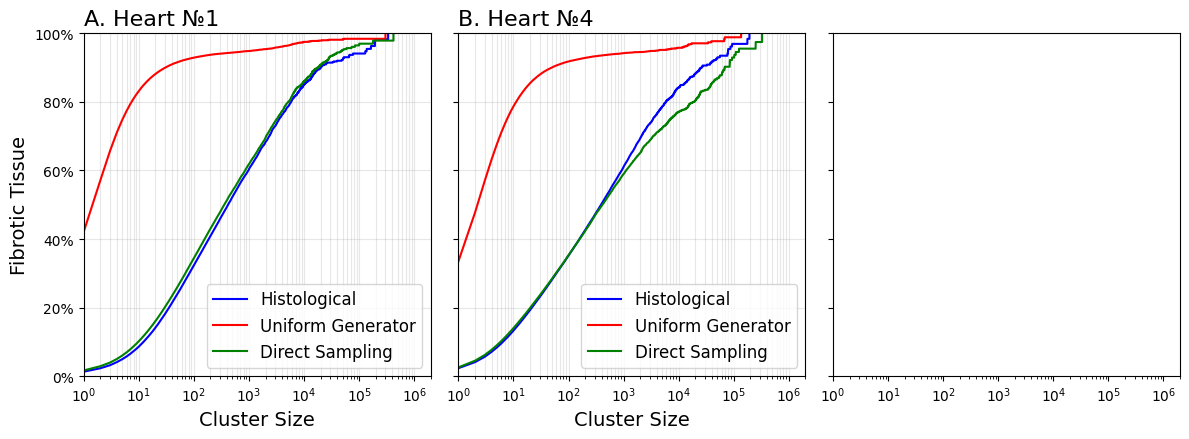

In [6]:
def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(df, ax, color='blue', label='Histological'):
    area_bins, cdf = calc_area_cdf(df)
    ax.plot(area_bins, cdf, label=label, color=color)


cdf_data = {'heart': [], 'area_bins': [], 'cdf': []}
cdf_gen_data = {'heart': [], 'area_bins': [], 'cdf': []}
ddf_ds_data = {'heart': [], 'area_bins': [], 'cdf': []}

fig, axs = plt.subplots(1, 3, figsize=(12, 4.5), sharex=True, sharey=True)

for i, heart in enumerate(hearts):
    df = data[heart]
    df_gen = data_gen[heart]

    area_bins, cdf = calc_area_cdf(df)
    cdf_data['heart'].append(heart)
    cdf_data['area_bins'].append(area_bins)
    cdf_data['cdf'].append(cdf)
    axs[i].plot(area_bins,
                cdf,
                label='Histological',
                color='blue')

    area_bins_gen, cdf_gen = calc_area_cdf(df_gen)
    cdf_gen_data['heart'].append(heart)
    cdf_gen_data['area_bins'].append(area_bins_gen)
    cdf_gen_data['cdf'].append(cdf_gen)
    axs[i].plot(area_bins_gen,
                cdf_gen,
                label='Uniform Generator',
                color='red')
    
    area_bins_ds, cdf_ds = calc_area_cdf(data_ds[heart])
    ddf_ds_data['heart'].append(heart)
    ddf_ds_data['area_bins'].append(area_bins_ds)
    ddf_ds_data['cdf'].append(cdf_ds)
    axs[i].plot(area_bins_ds,
                cdf_ds,
                label='Direct Sampling',
                color='green')

    axs[i].set_xscale('log')
    axs[i].set_xlabel('Cluster Size', fontsize=14)
    axs[i].set_title(titles[i], loc='left', fontsize=16)
    axs[i].grid(True, alpha=0.3, which='both')
    axs[i].legend(loc='lower right', fontsize=12)
    axs[i].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    axs[i].set_xlim(1, 2e6)
    axs[i].set_ylim(0, 1)

axs[0].set_ylabel('Fibrotic Tissue', fontsize=14)
plt.tight_layout()
plt.show()

In [53]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('area_cluster_size.png'),
            dpi=300, bbox_inches='tight')

In [57]:
def prob_thr(x, y, thr=10):
    return 100 * x[y >= thr].min()


cdf_data = pd.DataFrame(cdf_data)
cdf_gen_data = pd.DataFrame(cdf_gen_data)

for thr in [1, 10, 100]:
    cdf_data[f'A({thr})'] = cdf_data.apply(lambda x: prob_thr(x.cdf, 
                                                              x.area_bins, 
                                                              thr), axis=1)
    cdf_gen_data[f'A({thr})'] = cdf_gen_data.apply(lambda x: prob_thr(x.cdf, 
                                                                x.area_bins, 
                                                                thr), axis=1)
print(cdf_data[['heart', 'A(1)', 'A(10)', 'A(100)']])
# print(cdf_data.describe())
print(cdf_gen_data[['heart', 'A(1)', 'A(10)', 'A(100)']])    
                                    

           heart      A(1)      A(10)     A(100)
0   E10691_RBM20  1.302416   8.620958  32.338423
1    E11444_LMNA  2.320103  13.271548  35.177796
2  E10927_MYBPC3  0.954983   5.678693  15.526396
           heart       A(1)      A(10)     A(100)
0   E10691_RBM20  42.158086  83.184555  92.895879
1    E11444_LMNA  33.475109  78.693589  91.802791
2  E10927_MYBPC3  16.263607  43.279988  57.850921


--------------------
0.0927368416695958
0.32446282838821155
--------------------
--------------------
0.8405084234368568
0.9290927093300259
--------------------
--------------------
0.2508378035496013
0.5780094748706129
--------------------
--------------------
0.9184973280993949
0.9718685673573545
--------------------
--------------------
0.1298596071429043
0.33204874204300566
--------------------
--------------------
0.7699492935894381
0.9021172180852601
--------------------
--------------------
0.14045888090222416
0.3527882417978865
--------------------
--------------------
0.7983784336837976
0.9182584967977934
--------------------
--------------------
0.11169847061521405
0.30967980753443525
--------------------
--------------------
0.7259514083701951
0.8851455528391653
--------------------
--------------------
0.11670408455126169
0.3143979202255154
--------------------
--------------------
0.699698853802577
0.8902452576380929
--------------------
--------------------
0.101665287396

ValueError: zero-size array to reduction operation minimum which has no identity

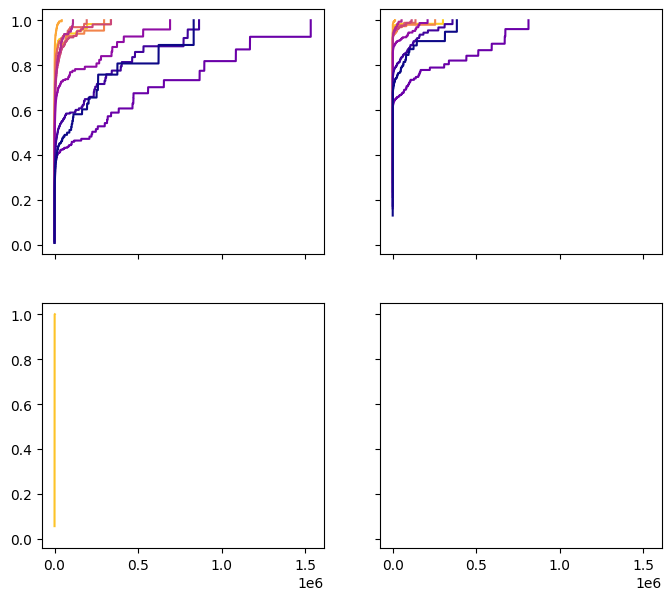

In [113]:
def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


heart_order = ['E10691_RBM20',
               'E11442_TTN',
               'E10621_ABCC9',
               'E11444_LMNA',
               'E10615_MYH7',
               'E11443_LMNA',
               'E11971_MYH7',
               'E10927_MYBPC3',
               'E10884',
               'E10788_LMNA']

colors_heart = plt.get_cmap('plasma_r')(np.linspace(0, 1, 1 + len(hearts)))[1:]
dens_bins = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1])
colors_dens = plt.get_cmap('plasma_r')(
    np.linspace(0, 1, 1 + len(dens_bins)))[1:]

fig, axs = plt.subplots(ncols=2,
                        nrows=2,
                        figsize=(8, 7),
                        sharex=True,
                        sharey=True)

for i, heart in enumerate(heart_order):
    df = data_all[data_all['heart'] == heart]
    area_bins, count = calc_area_cdf(df)
    axs[0, 0].plot(area_bins,
                   count,
                   label=f'{i+1}',
                   color=colors_heart[i])

    df_gen = data_gen_all[data_gen_all['heart'] == heart]
    area_bins, count = calc_area_cdf(df_gen)
    axs[0, 1].plot(area_bins,
                   count,
                   label=f'{i+1}',
                   color=colors_heart[i])

for i, (dens_min, dens_max) in enumerate(zip(dens_bins[:-1], dens_bins[1:])):
    df = data_all[data_all['density'].between(dens_min, dens_max)]
    area_bins, count = calc_area_cdf(df)
    axs[1, 0].plot(area_bins,
                   count,
                   label=f'{int(100 * dens_min)} - {int(100 * dens_max)}%',
                   color=colors[i])

    df_gen = data_gen_all[data_gen_all['density'].between(dens_min, dens_max)]
    area_bins, count = calc_area_cdf(df_gen)
    axs[1, 1].plot(area_bins,
                   count,
                   label=f'{int(100 * dens_min)} - {int(100 * dens_max)}%',
                   color=colors[i])

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.legend(loc='lower right',
              ncols=2 if ax in axs[0] else 1,
              fontsize=8,
              title='Heart' if ax in axs[0] else 'Fibrosis Density',
              title_fontsize=8)
    ax.grid(True, which='both', alpha=0.3)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

for i in range(2):
    axs[1, i].set_xlabel('Cluster Size', fontsize=12)
    axs[i, 0].set_ylabel('Fibrotic Tissue, %', fontsize=12)
    axs[0, i].set_title('A. Histology' if i == 0 else 'B. Uniform generator',
                        loc='left')
    axs[1, i].set_title('C. Histology' if i == 0 else 'D. Uniform generator',
                        loc='left')
plt.subplots_adjust(top=0.95, bottom=0.05, right=0.9, left=0.05,
                    wspace=0.15, hspace=0.15)
plt.show()

In [111]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('area_cluster_size.png'),
            dpi=300, bbox_inches='tight')